
<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# PyTorch Multiclass Classification #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

Pytorch documentation: <https://pytorch.org/docs/stable/index.html>

data source: https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity

# imports and graphics configurations #

In [ ]:
import os
import numpy
import pandas
idx=pandas.IndexSlice
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import sklearn.linear_model

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
import torch

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
#print([os.remove(f) for f in pngfiles])

existing png files: ['multiclass_scatterplot.png', 'polytope.png']


In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

# configuration variables #

In [ ]:
url="https://www.redfin.com"
fname=("redfin_data.csv","https://drive.google.com/file/d/1BFgKwV58YkPX_PRWMuKRHQoT6T0de_Qf/view?usp=sharing")
data_color="red"
markersize=2
thinlinesize=2
SEED=0

In [ ]:
featuredata=[("SQUARE FEET",1000,"SQUARE FEET/1000"),("$/SQUARE FEET",100,"$/100 SQUARE FEET")]
classname="PROPERTY TYPE"
classdata=[("Condo/Co-op",0),("Townhouse",1),("Single Family Residential",2)]

# load data #

In [ ]:
data_raw=getfile(fname)
data_raw.head()

local file not found; accessing Google Drive


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Condo/Co-op,1316 Maple Ave Unit A3,Evanston,IL,60201,549000,3.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1316-Maple-...,MRED,11329016,N,Y,42.041893,-87.685418
1,MLS Listing,NaN,Condo/Co-op,1640 Maple Ave #1608,Evanston,IL,60201,925000,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1640-Maple-...,MRED,11324990,N,Y,42.048207,-87.685582
2,MLS Listing,NaN,Single Family Residential,9400 Drake Ave,Evanston,IL,60203,699900,5.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/9400-Drake-...,MRED,11328594,N,Y,42.051958,-87.717069
3,MLS Listing,NaN,Condo/Co-op,2320 Central St #304,Evanston,IL,60201,315000,2.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2320-Centra...,MRED,11328430,N,Y,42.064059,-87.705756
4,MLS Listing,NaN,Townhouse,9032 Forestview Rd,Evanston,IL,60203,385000,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/9032-Forest...,MRED,11328152,N,Y,42.045487,-87.714740


In [ ]:
data=data_raw.copy()
data.index+=1
data.index.name="record number"

In [ ]:
(featurenames,featurescales,revisedfeaturenames)=list(zip(*featuredata))

In [ ]:
XY=pandas.DataFrame(0,index=data.index,columns=pandas.MultiIndex.from_product([["feature"],revisedfeaturenames]))
for (fname,scale,revisedfeaturename) in featuredata:
    XY[("feature",revisedfeaturename)]=data[fname]/scale

XY[("label","class")]=numpy.nan
for c,n in classdata:
    XY.loc[data["PROPERTY TYPE"]==c,("label","class")]=n

beforedrop=XY.shape[0]
XY=XY.dropna(axis='index')
XY[("label","class")]=XY[("label","class")].astype(numpy.int)
afterdrop=XY.shape[0]
print("{0:d} records dropped".format(beforedrop-afterdrop))
XY.head()

26 records dropped


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


feature                   label
              SQUARE FEET/1000 $/100 SQUARE FEET class
record number                                         
1                        2.000              2.75     0
2                        2.138              4.33     0
3                        2.198              3.18     2
4                        1.426              2.21     0
7                        2.170              3.41     2

In [ ]:
frequencies=XY.groupby(("label","class")).size().sort_index()
frequencies.name="frequencies"
print(frequencies)
weights=len(XY)/frequencies
weights.name="weights"
print(weights)

(label, class)
0    46
1     6
2    23
Name: frequencies, dtype: int64
(label, class)
0     1.630435
1    12.500000
2     3.260870
Name: weights, dtype: float64


In [ ]:
X=XY.loc[:,idx["feature",:]]
Y=XY[("label","class")]
X_1=XY.iloc[:,0]
X_2=XY.iloc[:,1]
X_1.name,_=X_1.name
X_2.name,_=X_2.name
flags=[(Y==c) for c in range(3)]

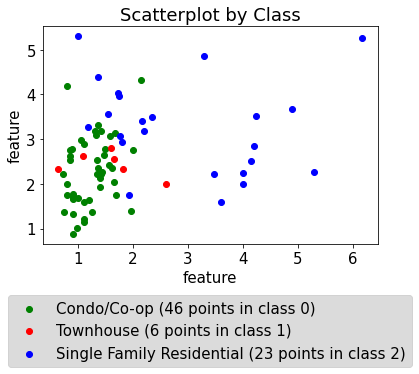

In [ ]:
plt.figure()
for (cname,cvalue),f,c in zip(classdata,flags,["green","red","blue"]):
    ff=flags[cvalue]
    plt.scatter(X_1[ff],X_2[ff],color=c,label="{0:s} ({1:d} points in class {2:n})".format(cname,ff.sum(),cvalue))
plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
legend("bottom",ncol=1)
title=[]
title.append("Scatterplot by Class")
plt.title("\n".join(title))
saver("multiclass_scatterplot")
plt.show()
plt.close()

In [ ]:
features=torch.from_numpy(XY.loc[:,idx["feature",:]].values.astype(numpy.float32).reshape(-1,len(featuredata)))
labels=torch.from_numpy(XY[("label","class")].values.astype(numpy.int))

if torch.cuda.is_available():
  print("cuda is available")
  features = features.cuda()
  labels = labels.cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
class feedForwardMultiClass(torch.nn.Module):
    def __init__(self,inputSize=1,NumClasses=2,SEED=0): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        if SEED is not None:
          torch.manual_seed(SEED)
        self.linear = torch.nn.Linear(inputSize,NumClasses)
        self.logSoftmax=torch.nn.LogSoftmax(dim=1)
        self.softmax=torch.nn.Softmax(dim=1)
        if torch.cuda.is_available():
          self=self.cuda()


    def forward(self,x,output="class"):
        out=self.linear(x)
        if output=="class":
          out=self.quantizer(out)
        elif output=="logprobability":
          out=self.logSoftmax(out)
        elif output=="probability":
          out=self.softmax(out)
        return out

    def quantizer(self,x):
      return torch.argmax(x,dim=1)


In [ ]:
model=feedForwardMultiClass(inputSize=2,NumClasses=3)
Loss=torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
print("set up complete")

set up complete


In [ ]:
MAX_iter = 50000
losses=[]
errors=[]
tic=time.perf_counter()
for itr in range(MAX_iter):


    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    output_x = model(features,output="logprobability")

    # get loss for the predicted output
    lossvalue = Loss(output_x, labels) #note order of labels and outputs
    losses.append(lossvalue.detach().numpy().item())
    output_classes=model.quantizer(output_x)
    error=(output_classes!=labels).to(torch.float).mean().item()
    errors.append(error)

    # get gradients w.r.t to parameters
    lossvalue.backward()

    # update parameters
    optimizer.step()
    if itr%int(MAX_iter/10)==0:
      output_distribution=numpy.unique(output_classes.detach().cpu().numpy(),return_counts=True)
      print("iteration {}: loss={:.5f}, errors={:.1%}%".
            format(itr, lossvalue.item(),error))

toc=time.perf_counter()
dt=toc-tic
print("done")

iteration 0: loss=1.04134, errors=38.7%%
iteration 5000: loss=0.48555, errors=16.0%%
iteration 10000: loss=0.45413, errors=16.0%%
iteration 15000: loss=0.45372, errors=16.0%%
iteration 20000: loss=0.45372, errors=16.0%%
iteration 25000: loss=0.45372, errors=16.0%%
iteration 30000: loss=0.45372, errors=16.0%%
iteration 35000: loss=0.45372, errors=16.0%%
iteration 40000: loss=0.45372, errors=16.0%%
iteration 45000: loss=0.45372, errors=16.0%%
done


In [ ]:
def polytope(mb1,mbothers,radius=1):
    #returns vertex and other points to plot in a ball around vertex of radius
    (m1,b1)=mb1
    ((m2,b2),(m3,b3))=mbothers
    A=numpy.vstack([numpy.array(m1)-numpy.array(m2),numpy.array(m1)-numpy.array(m3)])
    b=numpy.vstack([b1-b2,b1-b3])
    vertex=numpy.linalg.solve(A,-b).squeeze()
    p1=numpy.array([-A[0,1],A[0,0]])
    p2=numpy.array([A[1,1],-A[1,0]])
    dp=(p1-p2)/numpy.linalg.norm(p1-p2)
    nu=2*radius/numpy.linalg.norm(p2-p2.dot(dp)*dp)
    return vertex,[vertex+nu*p1,vertex+nu*p2]

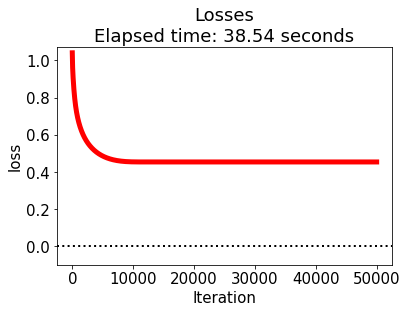

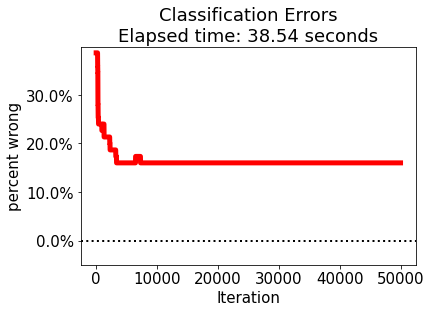

In [ ]:
plt.figure()
plt.plot(losses,color="red")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.ylim(-0.1,)
title=[]
title.append("Losses")
title.append("Elapsed time: {0:.02f} seconds".format(dt))
plt.title("\n".join(title))
plt.axhline(0,linewidth=2,linestyle=":",color="black")
plt.show()
plt.close()

plt.figure()
plt.plot(errors,color="red")
plt.xlabel("Iteration")
plt.ylabel("percent wrong")
plt.ylim(-0.05,)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
plt.axhline(0,linewidth=2,linestyle=":",color="black")
title=[]
title.append("Classification Errors")
title.append("Elapsed time: {0:.02f} seconds".format(dt))
plt.title("\n".join(title))
plt.show()
plt.close()

In [ ]:
 print(model.linear.weight.data)
 print(model.linear.bias.data)

tensor([[-1.9908, -0.6915],
        [-0.3291, -0.4572],
        [ 1.7671,  1.4570]])
tensor([ 6.5228,  1.6416, -6.7862])


In [ ]:
clf = sklearn.linear_model.LogisticRegression(random_state=0,solver="newton-cg").fit(XY.loc[:,idx["feature",:]].values, XY[("label","class")].values)
print(clf.coef_)
print(clf.intercept_)

[[-1.23240377 -0.63075061]
 [-0.09156908 -0.33441082]
 [ 1.32397285  0.96516144]]
[ 4.66326399  0.32411241 -4.9873764 ]


In [ ]:
print(XY.loc[:,idx["feature",:]].head())
print(XY[("label","class")].head())

                       feature                  
              SQUARE FEET/1000 $/100 SQUARE FEET
record number                                   
1                        2.000              2.75
2                        2.138              4.33
3                        2.198              3.18
4                        1.426              2.21
7                        2.170              3.41
record number
1    0
2    0
3    2
4    0
7    2
Name: (label, class), dtype: int64


In [ ]:
(m1,m2,m3)=model.linear.weight.data
(b1,b2,b3)=model.linear.bias.data

In [ ]:
def polytope(mb1,mbothers,radius=1):
    #returns vertex and other points to plot in a ball around vertex of radius
    (m1,b1)=mb1
    ((m2,b2),(m3,b3))=mbothers
    A=numpy.vstack([numpy.array(m1)-numpy.array(m2),numpy.array(m1)-numpy.array(m3)])
    b=numpy.vstack([b1-b2,b1-b3])
    signdet=numpy.sign(numpy.linalg.det(A))
    vertex=numpy.linalg.solve(A,-b).squeeze()
    p1=signdet*numpy.array([-A[0,1],A[0,0]])
    p2=signdet*numpy.array([A[1,1],-A[1,0]])
    dp=(p1-p2)/numpy.linalg.norm(p1-p2)
    nu=2*radius/numpy.linalg.norm(p2-p2.dot(dp)*dp)
    return vertex,[vertex+nu*p1,vertex+nu*p2]

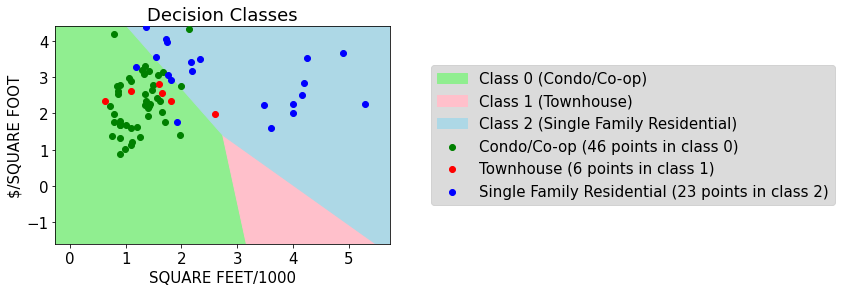

In [ ]:
plt.figure()
radius=3
v,[p1,p2]=polytope((m1,b1),[(m2,b2),(m3,b3)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))

plt.xlim(xstar-3,xstar+3)
plt.ylim(ystar-3,ystar+3)
plt.fill(x,y,color="lightgreen",label="Class 0 (Condo/Co-op)")

v,[p1,p2]=polytope((m2,b2),[(m3,b3),(m1,b1)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="pink",label="Class 1 (Townhouse)")

v,[p1,p2]=polytope((m3,b3),[(m1,b1),(m2,b2)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="lightblue",label="Class 2 (Single Family Residential)")


for (cname,cvalue),f,c in zip(classdata,flags,["green","red","blue"]):
    ff=flags[cvalue]
    plt.scatter(X_1[ff],X_2[ff],color=c,label="{0:s} ({1:d} points in class {2:n})".format(cname,ff.sum(),cvalue),zorder=5)
plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
legend("bottom",ncol=1)
legend("side")

plt.ylabel("$/SQUARE FOOT")
plt.xlabel("SQUARE FEET/1000")
title=[]
title.append("Decision Classes")
plt.title("\n".join(title))
saver("polytope")
plt.show()
plt.close()